In [ ]:
%pip install pyspark
from google.colab import drive
drive.mount('/content/drive')
import datetime as dt
import pyspark
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import count , countDistinct, lit, desc, col, sum, when, countDistinct, asc, monotonically_increasing_id, isnan, expr, mean, to_timestamp, collect_list, regexp_replace, max, to_date, unix_timestamp, concat, size, avg
import pyspark.sql.functions as ff
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import VectorAssembler,OneHotEncoder,StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns
%pip install networkx
import networkx as nx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Merge the 2 `CSV` Datasets

In [ ]:
df_1 = pd.read_csv("./drive/MyDrive/Sharables/SPRING 2023/CMPN451/project/Year 2009-2010.csv", encoding="ISO-8859-1", dtype={'Customer ID': str,'Invoice': str})
# df_1 = pd.read_csv("Year 2009-2010.csv", encoding="ISO-8859-1", dtype={'Customer ID': str,'Invoice': str})
df_2 = pd.read_csv("./drive/MyDrive/Sharables/SPRING 2023/CMPN451/project/Year 2010-2011.csv", encoding="ISO-8859-1", dtype={'Customer ID': str,'Invoice': str})
# df_2 = pd.read_csv("Year 2010-2011.csv", encoding="ISO-8859-1", dtype={'Customer ID': str,'Invoice': str})
df_3 = pd.concat([df_1, df_2], axis=0)
df_3.to_csv("./drive/MyDrive/Sharables/SPRING 2023/CMPN451/project/final_dataset.csv", index=False)
# df_3.to_csv("final_dataset.csv", index=False)

Start `Spark` session

In [ ]:
spark = SparkSession.builder\
    .master("local[*]")\
    .appName("dataProject")\
    .getOrCreate()

In [ ]:
sc=spark.sparkContext

Load dataset

In [ ]:
dataset = spark.read.csv("./drive/MyDrive/Sharables/SPRING 2023/CMPN451/project/final_dataset.csv", header=True, inferSchema=True)
# dataset = spark.read.csv("./final_dataset.csv", header=True, inferSchema=True)

# convert CustomerID and InvoiceID columns to string type
dataset = dataset.withColumn('Customer ID', col('Customer ID').cast('int'))
dataset = dataset.withColumn('Customer ID', col('Customer ID').cast('string'))
# dataset = dataset.withColumn('InvoiceID', col('InvoiceID').cast('string'))

Get information about dataset

In [ ]:
dataset.limit(10).toPandas()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085,United Kingdom
3,489434,22041,"""RECORD FRAME 7"""" SINGLE SIZE """,48,12/1/2009 7:45,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,12/1/2009 7:45,1.65,13085,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,12/1/2009 7:45,1.25,13085,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,12/1/2009 7:45,5.95,13085,United Kingdom
8,489435,22350,CAT BOWL,12,12/1/2009 7:46,2.55,13085,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,12/1/2009 7:46,3.75,13085,United Kingdom


In [ ]:
dataset.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Country: string (nullable = true)



In [ ]:
dataset.count()

1067371

In [ ]:
stat = dataset.describe()
stat.toPandas()

,summary,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,count,1067371,1067371,1062989,1067371,1067371,1067371,824364,1067371
1,mean,537608.1499316233,29011.161534536903,21848.25,9.9388984711033,None,4.64938772741339,15324.63850435002,None
2,stddev,26662.45044690152,18822.942866189253,922.9197780233488,172.7057940767531,None,123.55305872146401,1697.4644503793224,None
3,min,489434,10002,DOORMAT UNION JACK GUNS AND ROSES,-80995,1/10/2010 10:26,-53594.36,12346,Australia
4,max,C581569,m,wrongly sold sets,80995,9/9/2011 9:52,38970.0,18287,West Indies


Looks like there are NA values in `Description` and `Customer ID`, lets check for duplicated rows first before deciding how to deal with NA

In [ ]:
# group the DataFrame by all columns and count the number of occurrences
duplicate_count = dataset.groupBy(dataset.columns).count().filter('count > 1')

# count the number of duplicates
num_duplicates = duplicate_count.count()

# show the number of duplicates
print("Number of duplicates: ", num_duplicates)

Number of duplicates:  32907


Lets remove the duplicates

In [ ]:
dataset = dataset.dropDuplicates()

Lets deal with NA values in `Customer ID`, since the `Customer ID` is vital in our analysis in segmenting customers and Market Basket analysis, we can't just apply mode imputation on it as it will invalidate all our analysis.

But since every `Invoice` value is unique for every `Customer ID`, we can use it to replace the NAN `Customer ID` values with values found in other rows that have the same `Invoice` value.

So we need to check the validity of this strategy by checking if any `Invoice` value related to multiple `Customer ID` values (NaN and normal value)

In [ ]:
# Create a DataFrame with all rows where the customer ID is not null
valid_customers = dataset.filter(dataset["Customer ID"].isNotNull())

# Create a DataFrame with all rows where the customer ID is null
invalid_customers = dataset.filter(dataset["Customer ID"].isNull())

# Group the valid_customers DataFrame by Invoice and count the number of unique Customer IDs (including NaN) for each Invoice
valid_counts = valid_customers.groupBy("Invoice").agg(countDistinct("Customer ID").alias("Valid_Counts"))

# Check if there are any Invoices where the count of unique Customer IDs (including NaN) is greater than 1,
# AND if there are any Invoices in the invalid_customers DataFrame with the same Invoice number as one of those Invoices.
invalid_counts = invalid_customers.groupBy("Invoice").agg(countDistinct(when(isnan("Customer ID"), "Customer ID")).alias("Invalid_Counts"))
if valid_counts.join(invalid_counts, "Invoice").filter((valid_counts["Valid_Counts"] > 1) & (invalid_counts["Invalid_Counts"] > 0)).count() > 0:
    print("There is at least one Invoice with both valid and invalid Customer IDs.")
else:
    print("There are no Invoices with both valid and invalid Customer IDs.")

There are no Invoices with both valid and invalid Customer IDs.


Since there are no `Invoice` with both valid and NaN `Customer ID` values related to them, we will have tor **remove** the rows with NaN `Customer ID` values

In [ ]:
# drop rows with NaN customer ID
dataset = dataset.dropna(subset=["Customer ID"])

In [ ]:
stat = dataset.describe()
stat.toPandas()

,summary,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,count,797885,797885,797885,797885,797885,797885,797885,797885
1,mean,537427.0053906696,28838.943580758692,None,12.60298037937798,None,3.702731631743802,15313.062777217268,None
2,stddev,26901.961110079825,18539.515661212656,None,191.67037149741174,None,71.39254884125006,1696.4666629629605,None
3,min,489434,10002,DOORMAT UNION JACK GUNS AND ROSES,-80995,1/10/2010 10:26,0.0,12346,Australia
4,max,C581569,TEST002,ZINC WIRE SWEETHEART LETTER TRAY,80995,9/9/2011 9:52,38970.0,18287,West Indies


All the NA `Description` values were also removed.

From the Dataset website, all the `StockCode` values for products will contain 5-digits, since in the scope of the project we focus on the products and the customers, we will remove any `StockCode` that violates this

In [ ]:
pattern = r'\d{5}'
print(dataset.filter(~col('StockCode').rlike(pattern)).count())
dataset = dataset.filter(col('StockCode').rlike(pattern))

3662


Lets check if any of the remaining `Customer ID` values violate this rule.

In [ ]:
result = dataset.filter(~col("Customer ID").rlike(pattern))
result.show()

+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



Lets view outlier values in `Price` and `Quantity`

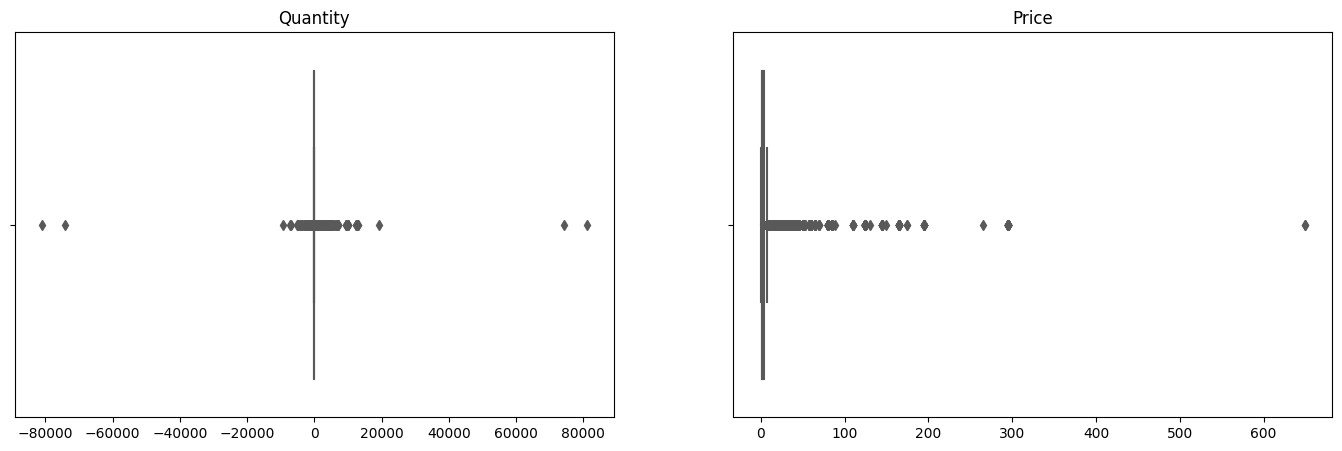

In [ ]:
quantity_data = dataset.select(col("Quantity")).rdd.flatMap(lambda x: x).collect()
price_data = dataset.select(col("Price")).rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(1,2, figsize=(17, 5))

sns.boxplot(x=quantity_data, orient="h", palette="Set2", ax=axes[0])
axes[0].title.set_text("Quantity")

sns.boxplot(x=price_data, orient="h", palette="Set2", ax=axes[1])
axes[1].title.set_text("Price")
plt.show()

In [ ]:
for col_name in ["Price", "Quantity"]:
  # Calculate the IQR for the UnitPrice column
  quantiles = dataset.approxQuantile(col_name, [0.25, 0.75], 0)
  iqr = quantiles[1] - quantiles[0]

  # Calculate the upper and lower bounds for outlier detection
  upper_bound = quantiles[1] + 3 * iqr
  lower_bound = quantiles[0] - 3 * iqr

  # Identify the outliers
  outliers = dataset.filter((col(col_name) > upper_bound) | (col(col_name) < lower_bound))

  # measure the percentage
  print(f"{col_name} outliers percentage: {round(outliers.count()/dataset.count() * 100, 2)}%")

Price outliers percentage: 2.25%
Quantity outliers percentage: 4.76%


Since the percentage of the detected outliers using the outer bound Tukey's method in both `Quantity` and `Price` is higher than 2%, we elected to leave them

lets look at the variable, starting with `Country`

In [ ]:
# print the number of countries in the dataset
countries = dataset.select('Country').distinct()
print('Number of countries in the dataset: {}'.format(countries.count()))
countries.toPandas()

Number of countries in the dataset: 41


,Country
0,Sweden
1,Singapore
2,Germany
3,RSA
4,France
5,Greece
6,Belgium
7,Finland
8,Malta
9,Unspecified


There are 9 customers with `unspecified` country origin, we will ignore them for now since we will not use `Country`

Get the number of orders per country

In [ ]:
# create a new column based on the condition that checks the value of the Country column
updated_dataset = dataset.withColumn('Updated Country', when(dataset['Country'] == 'EIRE', 'Ireland').otherwise(dataset['Country']))

# drop the original Country column and rename the Updated Country column to Country
updated_dataset = updated_dataset.drop('Country').withColumnRenamed('Updated Country', 'Country')


# Calculate the number of orders per country
orders_per_country = updated_dataset.dropDuplicates(["Invoice"])
orders_per_country = orders_per_country.groupBy('Country').agg(count('*').alias('count'))
orders_per_country = orders_per_country.orderBy(desc('count'))

# show the counts
display(orders_per_country.limit(5).toPandas())

# Convert orders_per_country to a pandas DataFrame
df = orders_per_country.toPandas()

# Define choropleth data
data = go.Choropleth(
    locations = df['Country'],
    locationmode = 'country names',
    z = df['count'],
    text = df['Country'],
    colorscale = [[0, 'rgb(224,255,255)'],
                  [0.01, 'rgb(166,206,227)'],
                  [0.02, 'rgb(31,120,180)'],
                  [0.03, 'rgb(178,223,138)'],
                  [0.05, 'rgb(51,160,44)'],
                  [0.10, 'rgb(251,154,153)'],
                  [0.20, 'rgb(255,255,0)'],
                  [1, 'rgb(227,26,28)']],
    colorbar = {'title':'Order nb.'},
    reversescale = False
)

# Define choropleth layout
layout = go.Layout(
    title = 'Number of orders per country',
    geo = dict(
        showframe = True,
        projection={'type':'mercator'},
    ),
    width=1200,  # Adjust the width of the entire figure
    height=800,  # Adjust the height of the entire figure
    margin=dict(l=10, r=10, t=50, b=50)  # Adjust the margins around the figure
)

# Create choropleth figure and display it
choromap = go.Figure(data = [data], layout = layout)
choromap.show()

,Country,count
0,United Kingdom,39854
1,Germany,1035
2,France,701
3,Ireland,661
4,Netherlands,228


In [ ]:
# create a new column based on the condition that checks the value of the Country column
updated_dataset = dataset.withColumn('Updated Country', when(dataset['Country'] == 'EIRE', 'Ireland').otherwise(dataset['Country']))

# drop the original Country column and rename the Updated Country column to Country
updated_dataset = updated_dataset.drop('Country').withColumnRenamed('Updated Country', 'Country')


purchase_value_per_country = updated_dataset.groupBy('Country').agg(sum('Price').alias('count'))
purchase_value_per_country = purchase_value_per_country.orderBy(desc('count'))
display(purchase_value_per_country.limit(5).toPandas())

# Convert purchase_value_per_country to a pandas DataFrame
df = purchase_value_per_country.toPandas()

# Define choropleth data
data = go.Choropleth(
    locations = df['Country'],
    locationmode = 'country names',
    z = df['count'],
    text = df['Country'],
    colorscale = [[0, 'rgb(224,255,255)'],
                  [0.01, 'rgb(166,206,227)'],
                  [0.02, 'rgb(31,120,180)'],
                  [0.03, 'rgb(178,223,138)'],
                  [0.05, 'rgb(51,160,44)'],
                  [0.10, 'rgb(251,154,153)'],
                  [0.20, 'rgb(255,255,0)'],
                  [1, 'rgb(227,26,28)']],
    colorbar = {'title':'Order nb.'},
    reversescale = False
)

# Define choropleth layout
layout = go.Layout(
    title = 'Purchase value per country',
    geo = dict(
        showframe = True,
        projection={'type':'mercator'}
    ),
    width=1200,  # Adjust the width of the entire figure
    height=800,  # Adjust the height of the entire figure
    margin=dict(l=10, r=10, t=50, b=50)  # Adjust the margins around the figure
)

# Create choropleth figure and display it
choromap = go.Figure(data = [data], layout = layout)
choromap.show()

,Country,count
0,United Kingdom,2.123222e+06
1,Ireland,5.481818e+04
2,Germany,4.614110e+04
3,France,3.512446e+04
4,Netherlands,1.193902e+04


Most of the orders and most revenue are made from the United Kingdoms

Lets see the number of products and customers

In [ ]:
# compute the number of unique products, transactions, and customers
products = dataset.select(countDistinct('StockCode').alias('products')).toPandas()
transactions = dataset.select(countDistinct('Invoice').alias('transactions')).toPandas()
customers = dataset.select(countDistinct('Customer ID').alias('customers')).toPandas()

# concatenate and show the results
pd.concat([products, transactions, customers], axis=1)

,products,transactions,customers
0,4633,43879,5876


5942 customers bought 4646 products, lets see the number of products purchased in every transaction

In [ ]:
# count the number of products in each invoice for each customer and 
temp = dataset.groupBy('Customer ID', 'Invoice') \
                 .agg(count('Invoice').alias('Number of products')) \
                 .select(['Customer ID', 'Invoice', 'Number of products'])

products_per_purchase =  temp.orderBy('Customer ID')
products_per_purchase.limit(20).toPandas()

,Customer ID,Invoice,Number of products
0,12346,513774,19
1,12346,499763,5
2,12346,541431,1
3,12346,C541433,1
4,12347,581180,11
5,12347,537626,31
6,12347,556201,18
7,12347,573511,47
8,12347,542237,29
9,12347,549222,24


Upon looking at dataset, we noticed that there are `invoice` values that start with `C` (which should indicates the transactions that have been canceled), and that there are customers who buys only 1 items, and there are customers that buys large number of items

lets see the invoices with transactions containing orders cancelled

In [ ]:
products_per_purchase = products_per_purchase.withColumn('order_canceled', when(col('Invoice').contains('C'), 1).otherwise(0))
display(products_per_purchase.limit(5).toPandas())

n1 = products_per_purchase.select(sum('order_canceled')).collect()[0][0]
n2 = products_per_purchase.count()
print(f'Number of orders canceled: {n1}/{n2} ({n1/n2*100:.2f}%)')

,Customer ID,Invoice,Number of products,order_canceled
0,12346,513774,19,0
1,12346,499763,5,0
2,12346,541431,1,0
3,12346,C541433,1,1
4,12347,537626,31,0


Number of orders canceled: 7282/43879 (16.60%)


16.6% of the total number of transactions were cancelling transactions (relatively large number)

17586


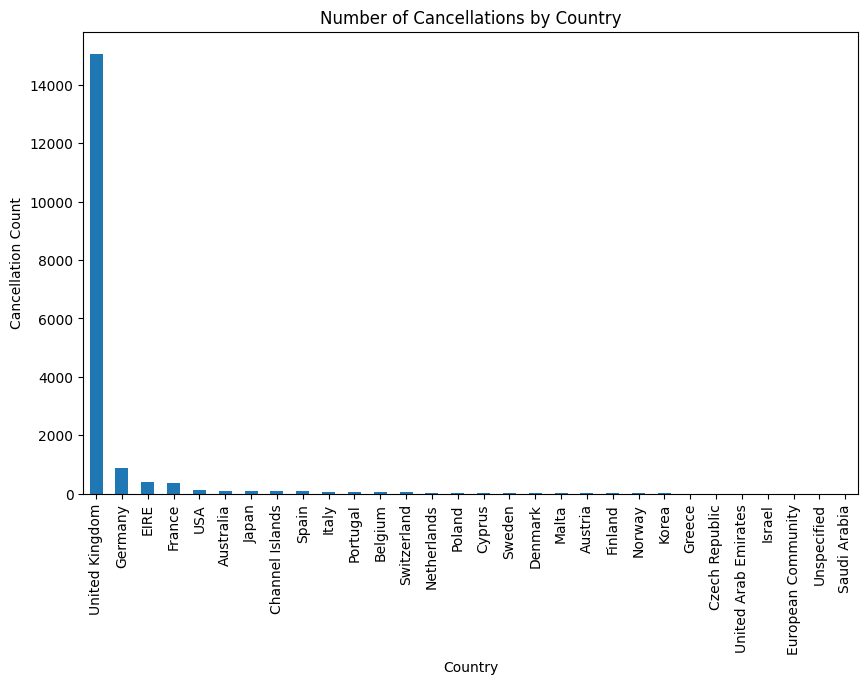

In [ ]:
# Create a new column 'is_canceled' that is True if Invoice starts with 'C', False otherwise
df = dataset.withColumn('is_canceled', when(dataset['Invoice'].startswith('C'), True).otherwise(False))

print(df.filter(df['is_canceled']).count())

# Group by country and count the number of cancellations
cancellation_counts = df.filter(df['is_canceled']).groupBy('Country').agg(count('Invoice').alias('cancellation_count'))

# Order by cancellation count in descending order
cancellation_counts = cancellation_counts.orderBy('cancellation_count', ascending=False)

# Convert the result to a Pandas DataFrame and plot the bar chart
cancellation_counts.toPandas().plot(kind='bar', x='Country', y='cancellation_count', legend=False, figsize=(10,6))
plt.xlabel('Country')
plt.ylabel('Cancellation Count')
plt.title('Number of Cancellations by Country')
plt.show()


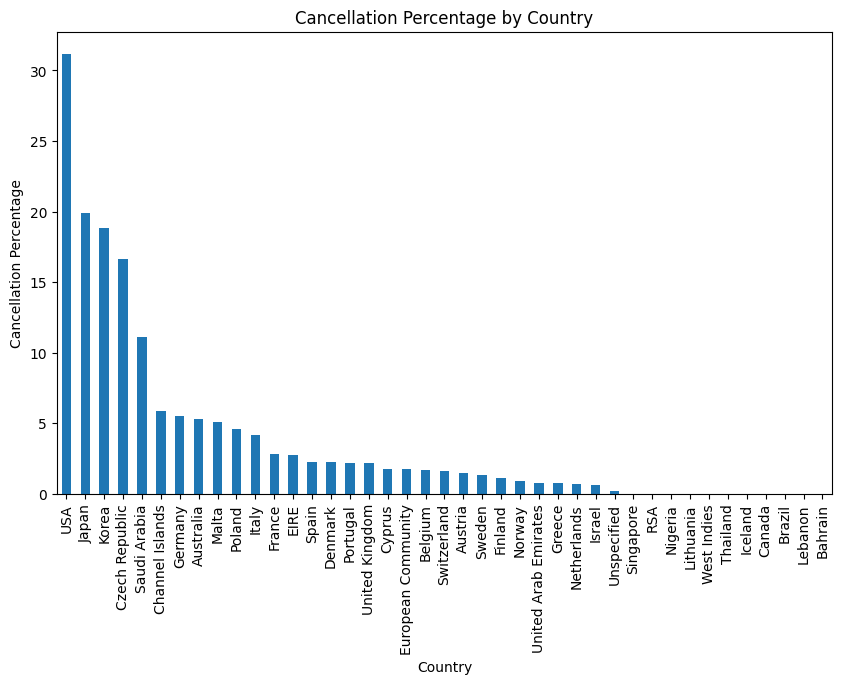

In [ ]:
from pyspark.sql.functions import count, when, col

# Calculate the total number of orders and the number of cancellations per country
orders_counts = df.groupBy('Country').agg(
    count('Invoice').alias('total_orders'),
    count(when(col('is_canceled') == True, True)).alias('cancellation_count')
)

# Calculate the percentage of cancellations for each country
orders_counts = orders_counts.withColumn(
    'cancellation_percentage',
    (col('cancellation_count') / (col('total_orders') - col('cancellation_count'))) * 100
)

# Order by cancellation percentage in descending order
orders_counts = orders_counts.orderBy('cancellation_percentage', ascending=False)

# Convert the result to a Pandas DataFrame and plot the bar chart
orders_counts.toPandas().plot(kind='bar', x='Country', y='cancellation_percentage', legend=False, figsize=(10, 6))
plt.xlabel('Country')
plt.ylabel('Cancellation Percentage')
plt.title('Cancellation Percentage by Country')
plt.show()

Lets look at the purchaese prices

In [ ]:
# Calculate TotalPrice column
dataset = dataset.withColumn('TotalPrice', expr('Price * Quantity'))

# Sort by CustomerID column and show the first 5 rows
df_sorted = dataset.orderBy(col('Customer ID'))
df_sorted.limit(5).toPandas()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,513774,22687,DOORMAT CHRISTMAS VILLAGE,1,6/28/2010 13:53,7.49,12346,United Kingdom,7.49
1,513774,48138,DOORMAT UNION FLAG,1,6/28/2010 13:53,7.49,12346,United Kingdom,7.49
2,513774,22365,DOORMAT RESPECTABLE HOUSE,1,6/28/2010 13:53,7.49,12346,United Kingdom,7.49
3,513774,21955,DOORMAT UNION JACK GUNS AND ROSES,1,6/28/2010 13:53,7.49,12346,United Kingdom,7.49
4,499763,20679,EDWARDIAN PARASOL RED,1,3/2/2010 13:08,5.95,12346,United Kingdom,5.95


In [ ]:
# from pyspark.sql.functions import col, sum, mean, to_timestamp


temp = dataset.groupBy('Customer ID', 'Invoice') \
                 .agg(sum('TotalPrice').alias('Basket Price'))

basket_price = temp.select(col('Customer ID'), col('Invoice'), col('Basket Price')) \
                  .withColumnRenamed('Basket Price', 'Basket_Price')


df_cleaned = dataset.withColumn('InvoiceDate_int', col('InvoiceDate'))
temp = df_cleaned.groupBy('Customer ID', 'Invoice') \
                 .agg(mean('InvoiceDate_int').alias('InvoiceDate_int'))

df_cleaned = df_cleaned.drop('InvoiceDate_int')

basket_price = basket_price.join(temp, ['Customer ID', 'Invoice'], 'inner') \
                           .withColumn('InvoiceDate', to_timestamp(col('InvoiceDate_int'))) \
                           .select(col('Customer ID'), col('Invoice'), col('Basket_Price'), col('InvoiceDate'))

basket_price = basket_price.filter(col('Basket_Price') > 0) \
                           .sort(col('Customer ID'))

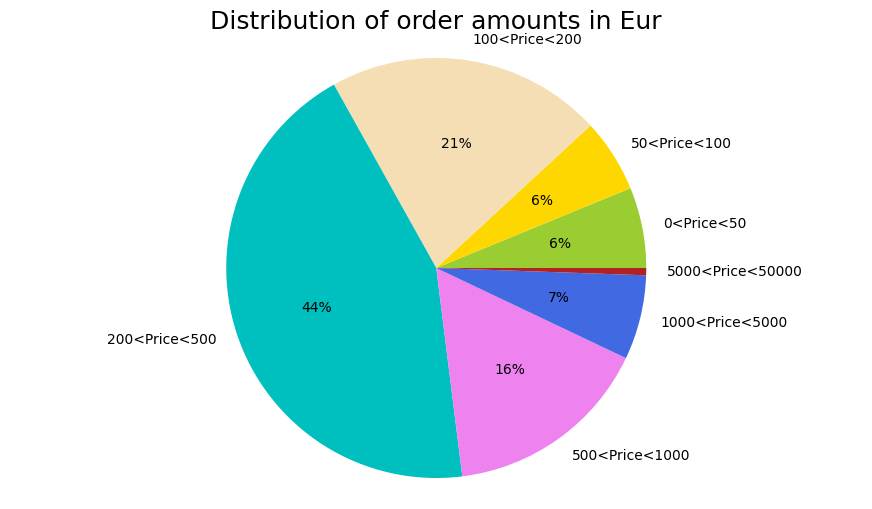

In [ ]:
import matplotlib.pyplot as plt

# Counting purchases
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]

count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price.filter((col('Basket_Price') < price) & (col('Basket_Price') > price_range[i-1])) \
                      .agg(count(col('Basket_Price')).alias('count')).collect()[0]['count']
    count_price.append(val)

# Visualization of the number of purchases per price range

fig, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = ['{}<Price<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
ax.set_title("Distribution of order amounts in Eur", fontsize = 18)
plt.show()

It is evident that a significant proportion of orders involve high-value purchases, as approximately 65% of purchases result in prices exceeding £200.

For the next part we will remove the cancelling transaction as we will focus more on what the customers buy in both the Market Basket Analysis and Customer Segmentation


In [ ]:
dataset = dataset.filter(~col('Invoice').startswith('C'))
dataset.filter(col('Invoice').startswith('C')).count()

0

We will perform first Market Basket Analysis

# MOSTAFA ABDELBRR

In [ ]:
# Clean up description column to remove typos.
basket_dataset = dataset.withColumn('Description', regexp_replace('Description', ' +{2,99}', ' '))
basket_dataset = basket_dataset.withColumn('Description', regexp_replace('Description', '^ +{2,99}', ''))
basket_dataset = basket_dataset.withColumn('Description', regexp_replace('Description', 'SET/', 'SET OF '))
basket_dataset = basket_dataset.withColumn('Description', regexp_replace('Description', '\+', ' '))
basket_dataset = basket_dataset.withColumn('Description', regexp_replace('Description', '\.', ''))
basket_dataset = basket_dataset.withColumn('Description', regexp_replace('Description', ' $', ''))
basket_dataset.show(truncate=False)

+-------+---------+-------------------------------------+--------+---------------+-----+-----------+--------------+------------------+
|Invoice|StockCode|Description                          |Quantity|InvoiceDate    |Price|Customer ID|Country       |TotalPrice        |
+-------+---------+-------------------------------------+--------+---------------+-----+-----------+--------------+------------------+
|489446 |21592    |RETRO SPOT CIGAR BOX MATCHES         |24      |12/1/2009 10:06|1.25 |13758      |United Kingdom|30.0              |
|489550 |21977    |PACK OF 60 PINK PAISLEY CAKE CASES   |48      |12/1/2009 12:33|0.55 |14156      |EIRE          |26.400000000000002|
|489556 |21114    |LAVENDER SCENTED FABRIC HEART        |15      |12/1/2009 12:47|1.25 |15719      |United Kingdom|18.75             |
|489574 |48185    |DOOR MAT FAIRY CAKE                  |1       |12/1/2009 13:31|6.75 |13097      |United Kingdom|6.75              |
|489579 |85136C   |RED SHARK HELICOPTER                

In [ ]:
def plot_bar_chart(rules_df, title):
    rules_df['antecedent'] = rules_df['antecedent'].apply(lambda x: ', '.join(x))
    rules_df['consequent'] = rules_df['consequent'].apply(lambda x: ', '.join(x))
    rules_df['rule'] = rules_df['antecedent'] + " => " + rules_df['consequent']
    
    rules_df.plot(x='rule', y='confidence', kind='bar', legend=False)
    plt.title(title)
    plt.ylabel('Confidence')
    plt.xticks(rotation=90)
    plt.show()

# rules_df = rules.limit(20).toPandas()
# plot_bar_chart(rules_df, 'Top 20 Association Rules')

In [ ]:
def draw_network_graph(rules_df, title):
    plt.figure(figsize=(10, 10))
    G = nx.DiGraph()
    
    for index, row in rules_df.iterrows():
        antecedent = ', '.join(row['antecedent'])
        consequent = ', '.join(row['consequent'])
        G.add_edge(antecedent, consequent, weight=round(row['confidence'], 2))
    
    pos = nx.spring_layout(G, seed=42)
    node_labels = {node: node for node in G.nodes()}
    
    nx.draw(G, pos, node_size=3000, alpha=0.6, node_color='lightblue', with_labels=False)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title(title)
    plt.axis('off')
    plt.show()

# rules_df = rules.limit(20).toPandas()
# draw_network_graph(rules_df, 'Top 20 Association Rules')

In [ ]:
def plot_scatterplot(rules_df, title):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=rules_df, x='support', y='confidence', hue='lift', size='lift', palette='viridis', sizes=(50, 200))
    plt.title(title)
    plt.xlabel('Support')
    plt.ylabel('Confidence')
    plt.legend(title='Lift', loc='upper right')
    plt.show()

def plot_metrics_relationship(rules):
    # Set up the style and figure size
    plt.figure(figsize=(15, 10))
    plt.style.use('seaborn-white')

    # Plot the relationship between the metrics
    plt.subplot(221)
    sns.scatterplot(x="support", y="confidence", data=rules)
    plt.subplot(222)
    sns.scatterplot(x="support", y="lift", data=rules)
    plt.subplot(223)
    sns.scatterplot(x="confidence", y="lift", data=rules)

    # Show the plot
    plt.show()

In [ ]:
def plot_heatmap(rules_df, title):
    rules_df['antecedent'] = rules_df['antecedent'].apply(lambda x: ', '.join(x))
    rules_df['consequent'] = rules_df['consequent'].apply(lambda x: ', '.join(x))
    
    pivot_table = rules_df.pivot(index='antecedent', columns='consequent', values='confidence')
    plt.figure(figsize=(10, 10))
    sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Confidence'})
    plt.title(title)
    plt.show()

def generate_lift_heatmap(rules):
    # Calculate the number of items in the left-hand side (antecedents)
    rules['lhs items'] = rules['antecedent'].apply(lambda x: len(x))

    # Replace the frozen sets with strings
    rules['antecedents_'] = rules['antecedent'].apply(lambda a: ','.join(list(a)))
    rules['consequents_'] = rules['consequent'].apply(lambda a: ','.join(list(a)))

    # Transform the DataFrame of rules into a matrix using the lift metric
    pivot = rules[rules['lhs items'] > 1].pivot(index='antecedents_', columns='consequents_', values='lift')

    # Generate a heatmap with annotations on and the colorbar off
    sns.heatmap(pivot, annot=True)
    plt.yticks(rotation=0)
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
# This cell and the following ones basically uses FP-growth to get association rules
# which gives us the top items associated/bought together.
basketdata = basket_dataset
basketdata = basketdata.dropDuplicates(['Description', 'Customer ID'])
basketdata = basketdata.groupBy("Customer ID").agg(collect_list("Description"))
fpGrowth = FPGrowth(itemsCol="collect_list(Description)", minSupport=0.05, minConfidence=0.05)
model = fpGrowth.fit(basketdata)
items = model.freqItemsets
rules = model.associationRules
rules = rules.orderBy(rules.confidence.desc())
# rules.limit(20).select('antecedent', 'consequent').show(truncate=False)
rules.limit(30).toPandas()

,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,[CANDLEHOLDER PINK HANGING HEART],[WHITE HANGING HEART T-LIGHT HOLDER],0.935385,3.674367,0.051939
3,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.922500,11.367142,0.063045
4,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
5,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
6,[POPPY'S PLAYHOUSE BEDROOM],[POPPY'S PLAYHOUSE KITCHEN],0.888594,12.685224,0.057236
7,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
9,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914


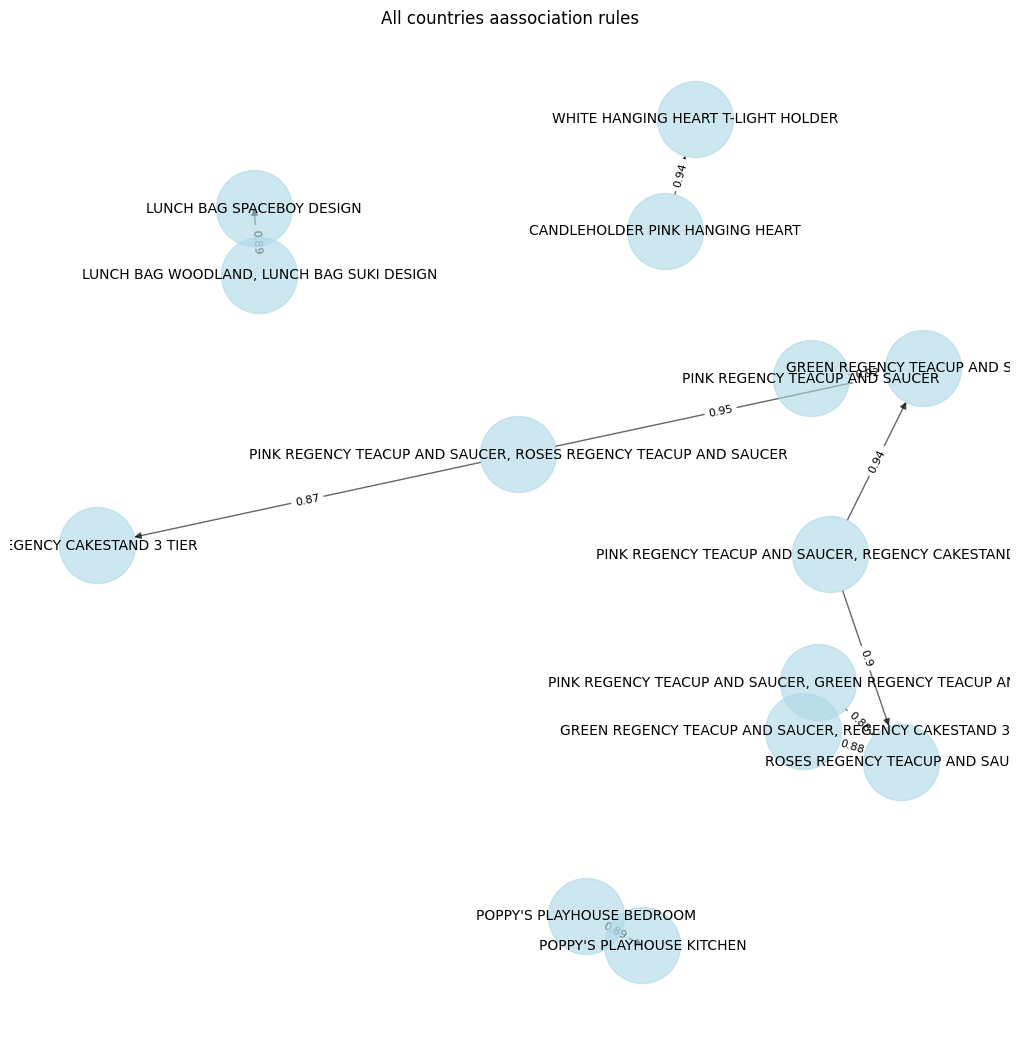

In [ ]:
draw_network_graph(rules.limit(10).toPandas(), "All countries aassociation rules")

<ipython-input-36-bc12d52fb15c>:13: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



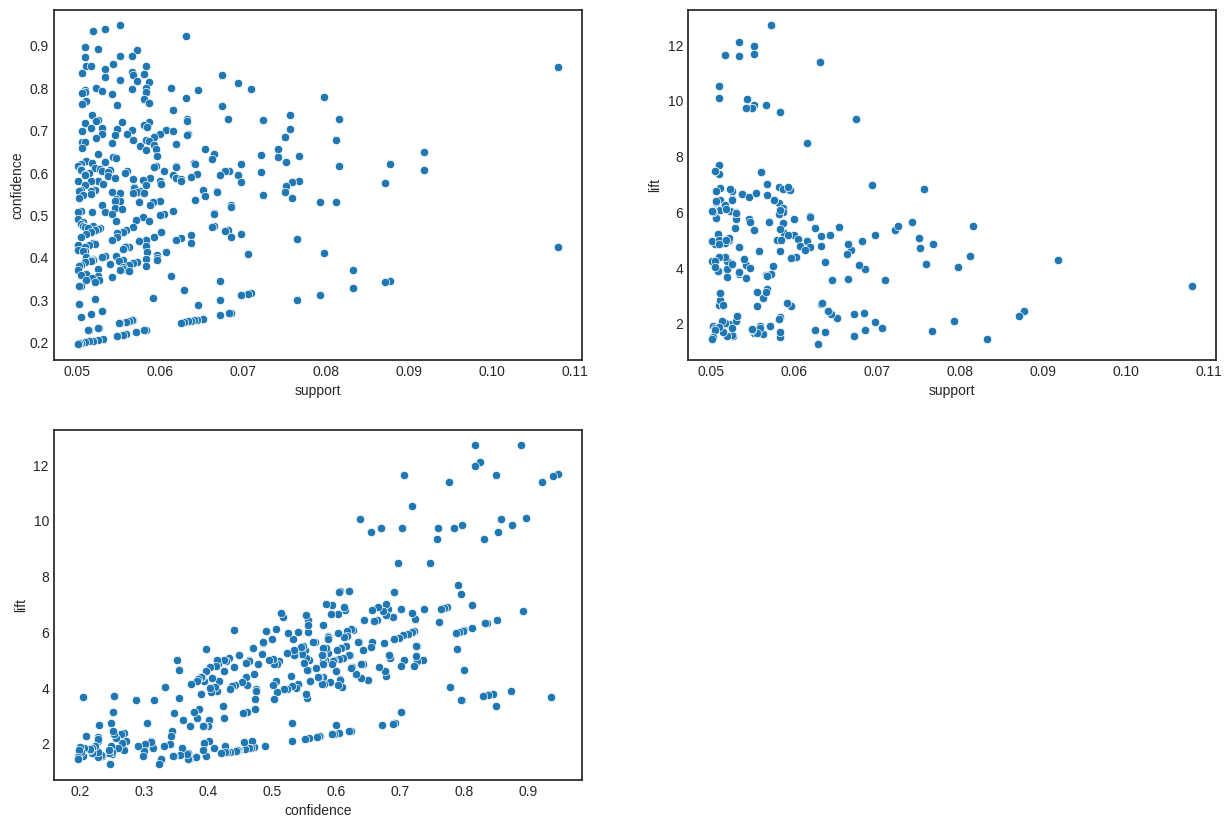

In [ ]:
from networkx.algorithms.cycles import recursive_simple_cycles
# plot_scatterplot(rules.toPandas(), "All countries scatterplot")
plot_metrics_relationship(rules.toPandas())

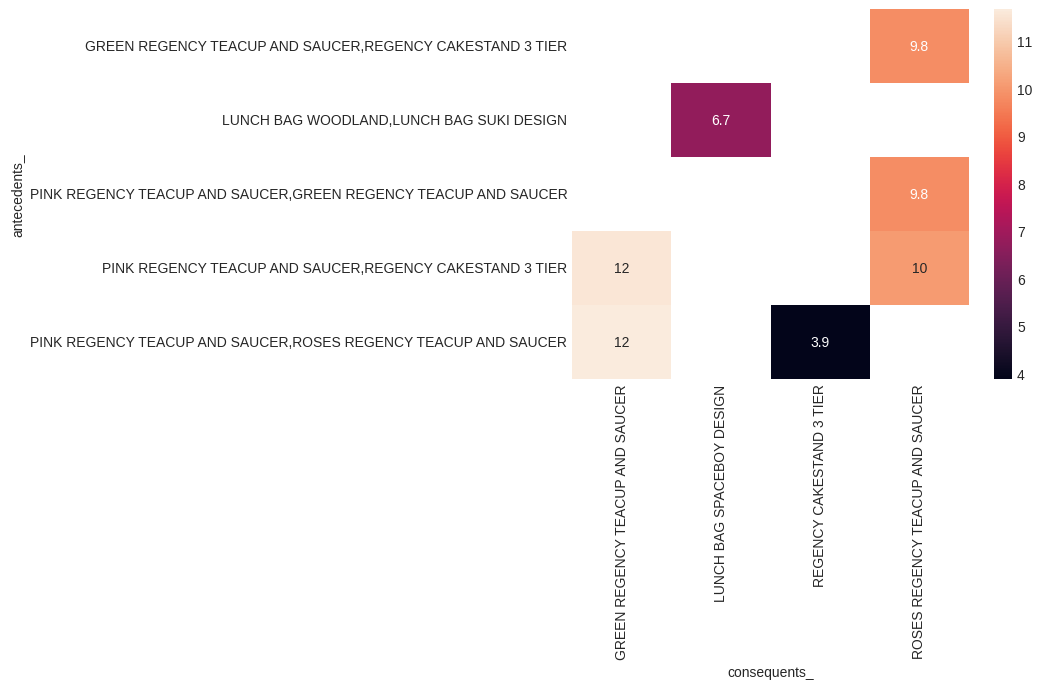

In [ ]:
generate_lift_heatmap(rules.limit(10).toPandas())

Based on the table, we can have discounts on small packages of these combinations on a global scale, and the manufacturerers will need to increase their manufacture quantities.

In [ ]:
top5Countries = list(purchase_value_per_country.limit(5).select('Country').toPandas()['Country'])
for country in top5Countries:
  basketdata = basket_dataset.where(basket_dataset.Country == country)
  basketdata = basket_dataset
  basketdata = basketdata.dropDuplicates(['Description', 'Customer ID'])
  basketdata = basketdata.groupBy("Customer ID").agg(collect_list("Description"))
  fpGrowth = FPGrowth(itemsCol="collect_list(Description)", minSupport=0.05, minConfidence=0.05)
  model = fpGrowth.fit(basketdata)
  items = model.freqItemsets
  rules = model.associationRules
  print(f"Country: {country}\nTop 10 Association Rules (minimum number of items = 3):")
  rules = rules.orderBy(rules.confidence.desc())
  display(rules.filter(size('antecedent') >= 2).limit(10).toPandas())
  print()
  print(f"Country: {country}\nTop 10 Association Rules (maximum number of items = 2):")
  display(rules.filter(size('antecedent') <= 2).limit(10).toPandas())
  print()

Country: United Kingdom
Top 10 Association Rules (minimum number of items = 3):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
3,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
4,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
5,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
6,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914
7,"[LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.851852,6.441717,0.051085
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[REGENCY CAKESTAND 3 TIER],0.845528,3.766269,0.053306
9,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",[REGENCY CAKESTAND 3 TIER],0.837975,3.732622,0.056552



Country: United Kingdom
Top 10 Association Rules (maximum number of items = 2):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,[CANDLEHOLDER PINK HANGING HEART],[WHITE HANGING HEART T-LIGHT HOLDER],0.935385,3.674367,0.051939
3,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.922500,11.367142,0.063045
4,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
5,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
6,[POPPY'S PLAYHOUSE BEDROOM],[POPPY'S PLAYHOUSE KITCHEN],0.888594,12.685224,0.057236
7,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
9,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914



Country: Ireland
Top 10 Association Rules (minimum number of items = 3):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
3,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
4,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
5,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
6,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914
7,"[LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.851852,6.441717,0.051085
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[REGENCY CAKESTAND 3 TIER],0.845528,3.766269,0.053306
9,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",[REGENCY CAKESTAND 3 TIER],0.837975,3.732622,0.056552



Country: Ireland
Top 10 Association Rules (maximum number of items = 2):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,[CANDLEHOLDER PINK HANGING HEART],[WHITE HANGING HEART T-LIGHT HOLDER],0.935385,3.674367,0.051939
3,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.922500,11.367142,0.063045
4,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
5,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
6,[POPPY'S PLAYHOUSE BEDROOM],[POPPY'S PLAYHOUSE KITCHEN],0.888594,12.685224,0.057236
7,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
9,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914



Country: Germany
Top 10 Association Rules (minimum number of items = 3):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
3,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
4,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
5,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
6,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914
7,"[LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.851852,6.441717,0.051085
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[REGENCY CAKESTAND 3 TIER],0.845528,3.766269,0.053306
9,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",[REGENCY CAKESTAND 3 TIER],0.837975,3.732622,0.056552



Country: Germany
Top 10 Association Rules (maximum number of items = 2):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,[CANDLEHOLDER PINK HANGING HEART],[WHITE HANGING HEART T-LIGHT HOLDER],0.935385,3.674367,0.051939
3,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.922500,11.367142,0.063045
4,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
5,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
6,[POPPY'S PLAYHOUSE BEDROOM],[POPPY'S PLAYHOUSE KITCHEN],0.888594,12.685224,0.057236
7,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
9,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914



Country: France
Top 10 Association Rules (minimum number of items = 3):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
3,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
4,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
5,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
6,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914
7,"[LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.851852,6.441717,0.051085
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[REGENCY CAKESTAND 3 TIER],0.845528,3.766269,0.053306
9,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",[REGENCY CAKESTAND 3 TIER],0.837975,3.732622,0.056552



Country: France
Top 10 Association Rules (maximum number of items = 2):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,[CANDLEHOLDER PINK HANGING HEART],[WHITE HANGING HEART T-LIGHT HOLDER],0.935385,3.674367,0.051939
3,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.922500,11.367142,0.063045
4,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
5,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
6,[POPPY'S PLAYHOUSE BEDROOM],[POPPY'S PLAYHOUSE KITCHEN],0.888594,12.685224,0.057236
7,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
9,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914



Country: Netherlands
Top 10 Association Rules (minimum number of items = 3):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
3,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
4,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
5,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
6,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914
7,"[LUNCH BAG RED RETROSPOT, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.851852,6.441717,0.051085
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[REGENCY CAKESTAND 3 TIER],0.845528,3.766269,0.053306
9,"[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",[REGENCY CAKESTAND 3 TIER],0.837975,3.732622,0.056552



Country: Netherlands
Top 10 Association Rules (maximum number of items = 2):


,antecedent,consequent,confidence,lift,support
0,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[GREEN REGENCY TEACUP AND SAUCER],0.947214,11.671672,0.055185
1,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[GREEN REGENCY TEACUP AND SAUCER],0.939759,11.579810,0.053306
2,[CANDLEHOLDER PINK HANGING HEART],[WHITE HANGING HEART T-LIGHT HOLDER],0.935385,3.674367,0.051939
3,[PINK REGENCY TEACUP AND SAUCER],[GREEN REGENCY TEACUP AND SAUCER],0.922500,11.367142,0.063045
4,"[PINK REGENCY TEACUP AND SAUCER, REGENCY CAKES...",[ROSES REGENCY TEACUP AND SAUCER],0.897590,10.083678,0.050914
5,"[LUNCH BAG WOODLAND, LUNCH BAG SUKI DESIGN]",[LUNCH BAG SPACEBOY DESIGN],0.892442,6.748659,0.052452
6,[POPPY'S PLAYHOUSE BEDROOM],[POPPY'S PLAYHOUSE KITCHEN],0.888594,12.685224,0.057236
7,"[GREEN REGENCY TEACUP AND SAUCER, REGENCY CAKE...",[ROSES REGENCY TEACUP AND SAUCER],0.875661,9.837324,0.056552
8,"[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",[ROSES REGENCY TEACUP AND SAUCER],0.875339,9.833700,0.055185
9,"[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",[REGENCY CAKESTAND 3 TIER],0.873900,3.892647,0.050914


In [ ]:
# countries = list(dataset.select('Country').distinct().toPandas()['Country'])
# for country in countries:
#   basketdata = dataset.where(dataset.Country == country)
#   basketdata = dataset
#   basketdata = basketdata.dropDuplicates(['Description', 'Customer ID'])
#   basketdata = basketdata.groupBy("Customer ID").agg(collect_list("Description"))
#   fpGrowth = FPGrowth(itemsCol="collect_list(Description)", minSupport=0.05, minConfidence=0.05)
#   model = fpGrowth.fit(basketdata)
#   items = model.freqItemsets
#   rules = model.associationRules
#   print(f"Country: {country}\nTop 10 Association Rules (minimum number of items = 3):")
#   rules.filter(size('antecedent') >= 2).limit(10).show(truncate=False)
#   print(f"Country: {country}\nTop 10 Association Rules (maximum number of items = 2):")
#   rules.filter(size('antecedent') <= 2).limit(10).show(truncate=False)

In [ ]:
# list_of_pds = []
# countries = list(dataset.select('Country').distinct().toPandas()['Country'])
# for country in countries:
#   basketdata = dataset.where(dataset.Country == country)
#   basketdata = dataset
#   basketdata = basketdata.dropDuplicates(['Description', 'Customer ID'])
#   basketdata = basketdata.groupBy("Customer ID").agg(collect_list("Description"))
#   fpGrowth = FPGrowth(itemsCol="collect_list(Description)", minSupport=0.05, minConfidence=0.05)
#   model = fpGrowth.fit(basketdata)
#   items = model.freqItemsets
#   rules = model.associationRules
#   print(f"Country: {country} Top 5:")
#   # rules.limit(5).select('antecedent', 'consequent').show(truncate=False)
#   temp_pd = rules.limit(5).select('antecedent', 'consequent').toPandas()
#   display(temp_pd)
#   print()
#   list_of_pds.append(temp_pd)

In [ ]:
dataset.limit(5).toPandas()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489446,21592,RETRO SPOT CIGAR BOX MATCHES,24,12/1/2009 10:06,1.25,13758,United Kingdom,30.00
1,489550,21977,PACK OF 60 PINK PAISLEY CAKE CASES,48,12/1/2009 12:33,0.55,14156,EIRE,26.40
2,489556,21114,LAVENDER SCENTED FABRIC HEART,15,12/1/2009 12:47,1.25,15719,United Kingdom,18.75
3,489574,48185,DOOR MAT FAIRY CAKE,1,12/1/2009 13:31,6.75,13097,United Kingdom,6.75
4,489579,85136C,RED SHARK HELICOPTER,1,12/1/2009 13:41,7.95,16887,United Kingdom,7.95


# SHAMS 1

In [ ]:
# Select the columns to be used for clustering
indexer = StringIndexer(inputCol="Country", outputCol="CountryIndex")
encoder = OneHotEncoder(inputCol="CountryIndex", outputCol="CountryVec")
columns = ["Quantity", "Price", "TotalPrice","CountryVec"]
assembler = VectorAssembler(inputCols=columns, outputCol="features")

In [ ]:
# Apply the VectorAssembler to the DataFrame to create a new DataFrame with a feature column
df_cleaned = indexer.fit(df_cleaned).transform(df_cleaned)
df_cleaned = encoder.fit(df_cleaned).transform(df_cleaned)
feature_df = assembler.transform(df_cleaned)
# Select only the feature column and the Customer ID column
cluster_df = feature_df.select("Customer ID", "features")

In [ ]:
# Train the KMeans model
# k = 8 # number of clusters
# max_iterations = 100 # maximum number of iterations
# kmeans = KMeans().setK(k).setMaxIter(max_iterations).setSeed(1)
# model = kmeans.fit(cluster_df)

In [ ]:
# predictions = model.transform(cluster_df).select("Customer ID", "prediction")
# predictions.groupBy("prediction").count().show()

In [ ]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Shams 2

In [ ]:
dataset_rfm = dataset.withColumn("Date", to_date(unix_timestamp("InvoiceDate", "MM/dd/yyyy").cast("timestamp")))
dataset_rfm = dataset_rfm.withColumn("RecencyDays", expr("datediff('2011-12-12', Date)"))

In [ ]:
max_date = dataset_rfm.agg(max("Date")).collect()[0][0]
print(max_date)

2011-12-09


Create rfm table (Recency, Frequency, Monetary)

In [ ]:
dataset_rfm.show()

+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+------------------+----------+-----------+
|Invoice|StockCode|         Description|Quantity|    InvoiceDate|Price|Customer ID|       Country|        TotalPrice|      Date|RecencyDays|
+-------+---------+--------------------+--------+---------------+-----+-----------+--------------+------------------+----------+-----------+
| 489446|    21592|RETRO SPOT  CIGAR...|      24|12/1/2009 10:06| 1.25|      13758|United Kingdom|              30.0|2009-12-01|        741|
| 489550|    21977|PACK OF 60 PINK P...|      48|12/1/2009 12:33| 0.55|      14156|          EIRE|26.400000000000002|2009-12-01|        741|
| 489556|    21114|LAVENDER SCENTED ...|      15|12/1/2009 12:47| 1.25|      15719|United Kingdom|             18.75|2009-12-01|        741|
| 489574|    48185| DOOR MAT FAIRY CAKE|       1|12/1/2009 13:31| 6.75|      13097|United Kingdom|              6.75|2009-12-01|        741|
| 489579|   8

In [ ]:
dataset_rfm.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalPrice: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- RecencyDays: integer (nullable = true)



In [ ]:
dataset_rfm.filter(dataset_rfm["RecencyDays"].isNull()).show()


+-------+---------+-----------+--------+-----------+-----+-----------+-------+----------+----+-----------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|TotalPrice|Date|RecencyDays|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+----------+----+-----------+
+-------+---------+-----------+--------+-----------+-----+-----------+-------+----------+----+-----------+



In [ ]:
rfm_table = dataset_rfm.groupBy("Customer ID")\
                        .agg(ff.min("RecencyDays").alias("Recency"), \
                             count("Invoice").alias("Frequency"), \
                             sum("TotalPrice").alias("Monetary"))

rfm_table = rfm_table.filter(col("monetary") > 0)

In [ ]:
rfm_table.show()

+-----------+-------+---------+------------------+
|Customer ID|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|      14204|      5|      220|           1024.83|
|      13192|     98|      162| 2558.579999999999|
|      13772|     36|      567| 3100.020000000001|
|      15555|     15|     1587|11233.779999999988|
|      17686|     10|      429| 8296.810000000009|
|      15271|     10|      570| 4528.540000000003|
|      17714|    323|       81|           1410.18|
|      14899|    398|      129|1331.3799999999999|
|      13610|     15|      398| 2102.460000000001|
|      16320|    175|      241| 5628.990000000001|
|      14838|    426|       70|            769.92|
|      15574|    180|      230|1101.4399999999996|
|      14157|     22|       85| 978.6899999999998|
|      12847|     25|      119|1609.0000000000002|
|      12529|    531|       21|            316.48|
|      13442|    670|       38|419.87000000000006|
|      14369|    645|       26|

In [ ]:
rfm_table_min = rfm_table.agg(ff.min("Monetary")).collect()[0][0]
rfm_table_min

2.95

In [ ]:
r_quartile = rfm_table.approxQuantile("Recency", [0.2, 0.4, 0.6, 0.8], 0)
f_quartile = rfm_table.approxQuantile("Frequency", [0.2, 0.4, 0.6, 0.8], 0)
m_quartile = rfm_table.approxQuantile("Monetary", [0.2, 0.4, 0.6, 0.8], 0)

rfm_table = rfm_table.withColumn("R_Quartile", \
                                 when(col("Recency") >= r_quartile[3] , 1).\
                                 when(col("Recency") >= r_quartile[2] , 2).\
                                 when(col("Recency") >= r_quartile[1] , 3).\
                                 when(col("Recency") >= r_quartile[0] , 4).\
                                 otherwise(5))

rfm_table = rfm_table.withColumn("F_Quartile", \
                                 when(col("Frequency") > f_quartile[3] , 5).\
                                 when(col("Frequency") > f_quartile[2] , 4).\
                                 when(col("Frequency") > f_quartile[1] , 3).\
                                 when(col("Frequency") > f_quartile[0] , 2).\
                                 otherwise(1))

rfm_table = rfm_table.withColumn("M_Quartile", \
                                 when(col("Monetary") >= m_quartile[3] , 5).\
                                 when(col("Monetary") >= m_quartile[2] , 4).\
                                 when(col("Monetary") >= m_quartile[1] , 3).\
                                 when(col("Monetary") >= m_quartile[0] , 2).\
                                 otherwise(1))

rfm_table = rfm_table.withColumn("RFM_Score", concat(col("R_Quartile"), col("F_Quartile"), col("M_Quartile")))

In [ ]:
rfm_table.show()

+-----------+-------+---------+------------------+----------+----------+----------+---------+
|Customer ID|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|
+-----------+-------+---------+------------------+----------+----------+----------+---------+
|      14204|      5|      220|           1024.83|         5|         5|         3|      553|
|      13192|     98|      162| 2558.579999999999|         3|         4|         4|      344|
|      13772|     36|      567| 3100.020000000001|         4|         5|         5|      455|
|      15555|     15|     1587|11233.779999999988|         5|         5|         5|      555|
|      17686|     10|      429| 8296.810000000009|         5|         5|         5|      555|
|      15271|     10|      570| 4528.540000000003|         5|         5|         5|      555|
|      17714|    323|       81|           1410.18|         2|         4|         4|      244|
|      14899|    398|      129|1331.3799999999999|         2

In [ ]:
from pyspark.sql.functions import when, col, lit

seg_map = {'[1-2][1-2]': 'hibernating',
           '[1-2][3-4]': 'at_Risk',
           '[1-2]5': 'cant_loose',
           '3[1-2]': 'about_to_sleep',
           '33': 'need_attention',
           '[3-4][4-5]': 'loyal_customers',
           '41': 'promising',
           '51': 'new_customers',
           '[4-5][2-3]': 'potential_loyalists',
           '5[4-5]': 'champions'}

# Create a new column "segment" with a default value of "unknown"
segmented_rfm_table = rfm_table.withColumn("segment", lit("unknown"))

# Update the "segment" column based on the RFM scores and the seg_map dictionary
for score, segment in seg_map.items():
    segmented_rfm_table = segmented_rfm_table.withColumn("segment", \
                                     when(col("RFM_Score").rlike(score), segment).otherwise(col("segment")))

In [ ]:
rfm_table.show()

+-----------+-------+---------+------------------+----------+----------+----------+---------+
|Customer ID|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|
+-----------+-------+---------+------------------+----------+----------+----------+---------+
|      14204|      5|      220|           1024.83|         5|         5|         3|      553|
|      13192|     98|      162| 2558.579999999999|         3|         4|         4|      344|
|      13772|     36|      567| 3100.020000000001|         4|         5|         5|      455|
|      15555|     15|     1587|11233.779999999988|         5|         5|         5|      555|
|      17686|     10|      429| 8296.810000000009|         5|         5|         5|      555|
|      15271|     10|      570| 4528.540000000003|         5|         5|         5|      555|
|      17714|    323|       81|           1410.18|         2|         4|         4|      244|
|      14899|    398|      129|1331.3799999999999|         2

**Champions:** These are your most valuable customers who have bought from you recently, frequently, and in large amounts. They are highly engaged with your business and are likely to be advocates for your brand.

**Loyal Customers:** These customers are highly engaged and make frequent purchases, but their monetary value is lower than champions. They are likely to be repeat buyers and loyal to your brand.

**Potential Loyalists:** These customers have made more recent purchases but may not have been consistent with their buying frequency or monetary value. They have the potential to become loyal customers with a little encouragement.

**Recent Customers:** These customers have made recent purchases but may not have returned frequently or spent a significant amount of money. They are still getting to know your brand and need to be engaged with relevant messaging and offers.

**Promising:** These customers have made a high-value purchase in the past, but haven't made a purchase recently. They need to be re-engaged with your brand through targeted messaging and offers.

**Needs Attention:** These customers haven't made a purchase in a while and have low purchase frequency and monetary value. They are at risk of being lost and need to be re-engaged with targeted messaging and offers.

**About to Sleep:** These customers have low purchase frequency and monetary value but have made purchases more recently. They are at risk of becoming inactive and need to be re-engaged with targeted messaging and offers.

**At Risk:** These customers have made purchases in the past but haven't been active recently. They are at risk of being lost and need to be re-engaged with targeted messaging and offers.

**Cant Lose Them:** These customers used to be high-value customers but haven't made a purchase recently. They are still engaged with your brand and should be re-engaged with targeted messaging and offers to prevent churn.

**Hibernating:** These customers have made no purchases in a while and have low purchase frequency and monetary value. They are at high risk of being lost and need to be re-engaged with targeted messaging and offers.

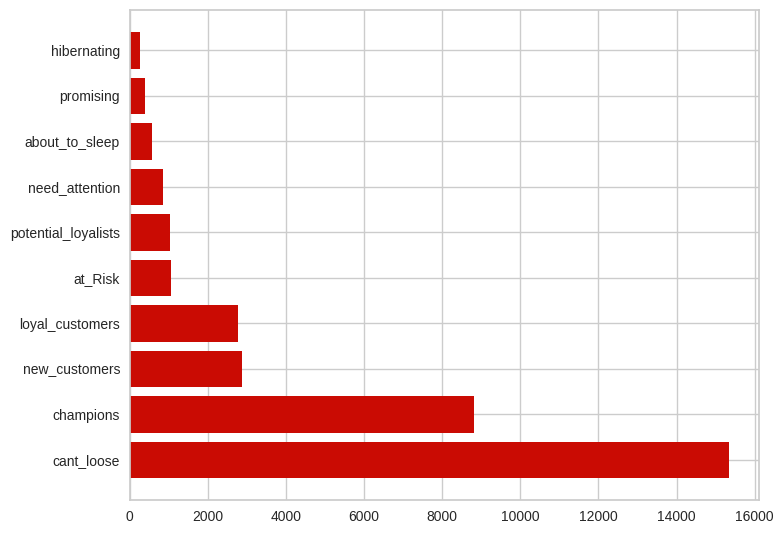

In [ ]:
# from pyspark.sql.functions import mean
import matplotlib.pyplot as plt

graph1 = segmented_rfm_table.groupBy("segment").agg(mean("monetary").alias("monetary_mean")).orderBy("monetary_mean", ascending=False)
segment_names = [row.segment for row in graph1.collect()]
monetary_means = [row.monetary_mean for row in graph1.collect()]

plt.barh(segment_names, monetary_means, color="r")
plt.tight_layout()
plt.show()


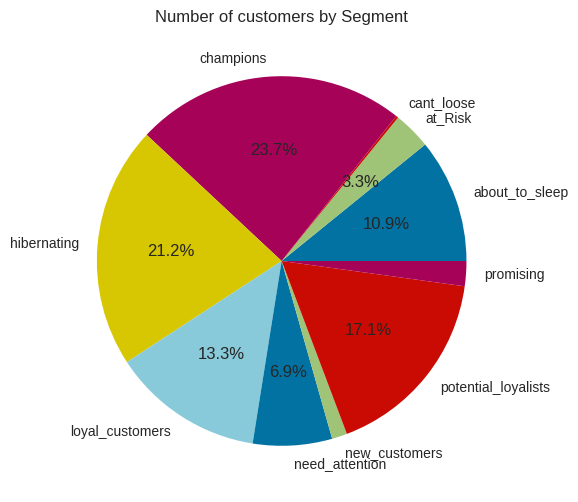

In [ ]:
import matplotlib.pyplot as plt

# Custom function to display percentages only if the value is >= 3%
def autopct_conditional(pct):
    return f'{pct:.1f}%' if pct >= 3 else ''

# Get the count of rows for each segment
segment_monetary = segmented_rfm_table.groupBy("segment").agg({"Monetary": "count"}).sort("segment")

# Convert the data to Pandas dataframe
segment_monetary_pd = segment_monetary.toPandas()

# Plot the pie chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(segment_monetary_pd["count(Monetary)"], labels=segment_monetary_pd["segment"], autopct=autopct_conditional)
ax.set_title("Number of customers by Segment")

plt.show()

In [ ]:
rfm_table_with_country = segmented_rfm_table.join(dataset_rfm.select("Customer ID", "Country"), "Customer ID", "left")

In [ ]:


# Calculate the average recency for each country
avg_recency_by_country = rfm_table_with_country.groupBy('Country').agg(ff.avg('Recency').alias('avg_recency'))

# Order the results by average recency in descending order
avg_recency_by_country = avg_recency_by_country.orderBy('avg_recency', ascending=False)

# Select the country with the highest average recency
highest_avg_recency_country = avg_recency_by_country.first()['Country']

# Print the result
print("The country with the highest average recency is:", highest_avg_recency_country)

The country with the highest average recency is: Thailand


In [ ]:
avg_recency_by_country.toPandas()

,Country,avg_recency
0,Thailand,525.000000
1,Nigeria,479.000000
2,West Indies,476.000000
3,Korea,392.150943
4,RSA,388.729508
5,United Arab Emirates,377.134211
6,Brazil,376.872340
7,Lithuania,369.000000
8,Lebanon,319.000000
9,Greece,305.486983


In [ ]:
from pyspark.sql.functions import mean, count, sum

segmented_rfm_table.groupby("Segment").agg(
  mean("recency").alias("mean_recency"),
  mean("frequency").alias("mean_frequency"),
  mean("monetary").alias("mean_monetary"),
  count("Segment").alias("count"),
  sum("recency").alias("sum_recency"),
  sum("frequency").alias("sum_frequency"),
  sum("monetary").alias("sum_monetary")
).toPandas()


,Segment,mean_recency,mean_frequency,mean_monetary,count,sum_recency,sum_frequency,sum_monetary
0,loyal_customers,170.642214,103.873874,2782.830309,777,132589,80710,2162259.15
1,promising,46.070312,12.453125,390.129922,128,5897,1594,49936.63
2,at_Risk,391.523316,23.352332,1060.796684,193,75564,4507,204733.76
3,need_attention,260.400000,52.437037,852.214790,405,105462,21237,345146.99
4,new_customers,12.987179,8.820513,2879.839359,78,1013,688,224627.47
5,about_to_sleep,218.094488,28.355906,557.812189,635,138490,18006,354210.74
6,hibernating,458.664245,15.191283,253.431178,1239,568285,18822,314001.23
7,potential_loyalists,84.888889,70.878879,1027.274765,999,84804,70808,1026247.49
8,cant_loose,441.500000,16.333333,15341.459167,12,5298,196,184097.51
9,champions,49.774892,404.089466,8804.694805,1386,68988,560068,12203307.00


In [ ]:
rfm_table.show()

+-----------+-------+---------+------------------+----------+----------+----------+---------+
|Customer ID|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|
+-----------+-------+---------+------------------+----------+----------+----------+---------+
|      14204|      5|      220|           1024.83|         5|         5|         3|      553|
|      13192|     98|      162| 2558.579999999999|         3|         4|         4|      344|
|      13772|     36|      567| 3100.020000000001|         4|         5|         5|      455|
|      15555|     15|     1587|11233.779999999988|         5|         5|         5|      555|
|      17686|     10|      429| 8296.810000000009|         5|         5|         5|      555|
|      15271|     10|      570| 4528.540000000003|         5|         5|         5|      555|
|      17714|    323|       81|           1410.18|         2|         4|         4|      244|
|      14899|    398|      129|1331.3799999999999|         2

In [ ]:
kmeans_rdm_table = rfm_table

In [ ]:
import builtins



# Define the Map and Reduce functions for MinMaxScaler
def map_min_max(row):
    values = [(i, (row[i], row[i])) for i in ['Recency', 'Frequency', 'Monetary']]
    return values

def reduce_min_max(a, b):
    return (min(a[0], b[0]), builtins.max(a[1], b[1]))

# Compute the minimum and maximum values for each feature
min_max_rdd = kmeans_rdm_table.rdd.flatMap(map_min_max).reduceByKey(reduce_min_max)
min_max_values = min_max_rdd.collectAsMap()

# Apply the MinMax scaling formula to each feature
def scale_row(row):
    scaled_recency = (row.Recency - min_max_values['Recency'][0]) / (min_max_values['Recency'][1] - min_max_values['Recency'][0])
    scaled_frequency = (row.Frequency - min_max_values['Frequency'][0]) / (min_max_values['Frequency'][1] - min_max_values['Frequency'][0])
    scaled_monetary = (row.Monetary - min_max_values['Monetary'][0]) / (min_max_values['Monetary'][1] - min_max_values['Monetary'][0])
    return (row['Customer ID'], scaled_recency, scaled_frequency, scaled_monetary)

scaled_rfm_table = kmeans_rdm_table.rdd.map(scale_row).toDF(["Customer ID", "Recency", "Frequency", "Monetary"])

In [ ]:
scaled_rfm_table.printSchema()

root
 |-- Customer ID: string (nullable = true)
 |-- Recency: double (nullable = true)
 |-- Frequency: double (nullable = true)
 |-- Monetary: double (nullable = true)



In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as ff
from pyspark.sql.types import *
import random
import numpy as np

from pyspark.sql.types import IntegerType, StructType, StructField, StringType, ArrayType, DoubleType

# # Initialize SparkSession
# spark = SparkSession.builder.master("local").appName("K-means MapReduce").getOrCreate()

# # Load your DataFrame
# # scaled_rfm_table = ...

# # Define the number of clusters and maximum iterations
# k = 3
# max_iterations = 100

# # Initialize the centroids randomly as NumPy arrays
# centroids = [np.array([row.Recency, row.Frequency, row.Monetary], dtype=np.float64) for row in scaled_rfm_table.rdd.takeSample(False, k, seed=42)]

# def closest_centroid(point, centroids):
#     point = np.array(point, dtype=np.float64)
#     centroids = [np.array(centroid, dtype=np.float64) for centroid in centroids]
#     distances = [np.linalg.norm(point - centroid) for centroid in centroids]
#     return np.argmin(distances)

# # Define the map and reduce functions
# def map_function(row):
#     point = np.array([row.Recency, row.Frequency, row.Monetary], dtype=np.float64)
#     centroid_idx = closest_centroid(point, centroids)
#     return (centroid_idx, (point.reshape(1, -1), 1))

# def reduce_function(x, y):
#     point_sum = np.add(x[0], y[0])
#     count = x[1] + y[1]
#     return (point_sum.reshape(1, -1), count)

# # Run K-means algorithm
# for i in range(max_iterations):
#     # Map each data point to the closest centroid
#     mapped_rdd = scaled_rfm_table.rdd.map(map_function)

#     # Reduce by key to compute the sum of points and count for each centroid
#     reduced_rdd = mapped_rdd.reduceByKey(reduce_function)

#     # Update centroids by computing the mean of all data points assigned to each centroid
#     new_centroids = reduced_rdd.map(lambda x: x[1][0] / x[1][1]).collect()

#     # Check for convergence
#     if np.allclose(centroids, new_centroids, rtol=1e-4):
#         break

#     centroids = new_centroids

# # Print the final centroids
# print("Final centroids:", centroids)

############################################################################################################

from pyspark.sql import SparkSession
import pyspark.sql.functions as ff
from pyspark.sql.types import IntegerType, StructType, StructField, StringType, ArrayType, DoubleType


# Broadcast the initial centroids
k = 8
initial_centroids = scaled_rfm_table.rdd.map(lambda x: [float(x["Recency"]), float(x["Frequency"]), float(x["Monetary"])]).takeSample(False, k)
centroids = spark.sparkContext.broadcast(initial_centroids)

# Define the distance function
def squared_distance(x, y):
    distance = 0
    for xi, yi in zip(x, y):
        distance += (xi - yi) ** 2
    return distance

# Map phase: assign each point to the closest centroid
def map_phase(row):
    rfm = [float(row["Recency"]), float(row["Frequency"]), float(row["Monetary"])]
    # find the index of the centroid of the nearest distance
    closest_centroid_idx = min(range(len(centroids.value)), key=lambda i: squared_distance(rfm, centroids.value[i]))
    return closest_centroid_idx, (rfm, 1)
    # index of the closest centroid (the row values, 1)

# Combiner phase: calculate the intermediate cluster mean and the number of instances
def combiner(x, y):
    combined_rfm = [(xi * x[1] + yi * y[1]) / (x[1] + y[1]) for xi, yi in zip(x[0], y[0])]
    return combined_rfm, x[1] + y[1]
    # the immediate mean point, sum of ones

# Run K-means until convergence
max_iterations = 1000
tolerance = 1e-4
for _ in range(max_iterations):
    # Map and reduce
    rfm_data = scaled_rfm_table.rdd.map(map_phase).reduceByKey(combiner).collect()

    # Update centroids
    new_centroids = [row[1][0] for row in rfm_data]
    if all(squared_distance(c1, c2) < tolerance for c1, c2 in zip(centroids.value, new_centroids)):
        break
    centroids = spark.sparkContext.broadcast(new_centroids)

# Assign data points to clusters by their centroids
schema = StructType([
    StructField("Customer ID", StringType(), True),
    StructField("RFM", ArrayType(DoubleType()), True),
    StructField("Cluster", IntegerType(), True)
])

clustered_rfm_table_rdd = scaled_rfm_table.rdd.map(lambda row: (row["Customer ID"], [float(row["Recency"]), float(row["Frequency"]), float(row["Monetary"])], map_phase(row)[0]))
clustered_rfm_table = spark.createDataFrame(clustered_rfm_table_rdd, schema)

# Add 1 to the values in the "Cluster" column
clustered_rfm_table = clustered_rfm_table.withColumn("Cluster", expr("Cluster + 1"))

# Display the results
clustered_rfm_table.show()

+-----------+--------------------+-------+
|Customer ID|                 RFM|Cluster|
+-----------+--------------------+-------+
|      14204|[0.00271002710027...|      1|
|      13192|[0.12872628726287...|      2|
|      13772|[0.04471544715447...|      1|
|      15555|[0.01626016260162...|      1|
|      17686|[0.00948509485094...|      1|
|      15271|[0.00948509485094...|      1|
|      17714|[0.43360433604336...|      3|
|      14899|[0.53523035230352...|      4|
|      13610|[0.01626016260162...|      1|
|      16320|[0.23306233062330...|      5|
|      14838|[0.57317073170731...|      4|
|      15574|[0.23983739837398...|      5|
|      14157|[0.02574525745257...|      1|
|      12847|[0.02981029810298...|      1|
|      12529|[0.71544715447154...|      6|
|      13442|[0.90379403794037...|      6|
|      14369|[0.86991869918699...|      6|
|      16576|[0.56910569105691...|      4|
|      17401|[0.73306233062330...|      6|
|      13282|[0.02439024390243...|      1|
+----------

In [ ]:
cluster_counts = clustered_rfm_table.groupBy("Cluster").count()

cluster_counts.show()

+-------+-----+
|Cluster|count|
+-------+-----+
|      1| 1642|
|      6|  604|
|      3|  469|
|      5|  487|
|      4| 1031|
|      8|   14|
|      7| 1046|
|      2|  559|
+-------+-----+



In [ ]:
# Perform a join operation to add the "Cluster" column to rfm_table
rfm_table_with_cluster = rfm_table.join(clustered_rfm_table, "Customer ID", "left")

# Display the updated DataFrame
rfm_table_with_cluster.show()

+-----------+-------+---------+------------------+----------+----------+----------+---------+--------------------+-------+
|Customer ID|Recency|Frequency|          Monetary|R_Quartile|F_Quartile|M_Quartile|RFM_Score|                 RFM|Cluster|
+-----------+-------+---------+------------------+----------+----------+----------+---------+--------------------+-------+
|      14204|      5|      220|           1024.83|         5|         5|         3|      553|[0.00271002710027...|      1|
|      13192|     98|      162| 2558.579999999999|         3|         4|         4|      344|[0.12872628726287...|      2|
|      13772|     36|      567| 3100.020000000001|         4|         5|         5|      455|[0.04471544715447...|      1|
|      15555|     15|     1587|11233.779999999988|         5|         5|         5|      555|[0.01626016260162...|      1|
|      17686|     10|      429| 8296.810000000009|         5|         5|         5|      555|[0.00948509485094...|      1|
|      15271|   

In [ ]:
cluster_counts = rfm_table_with_cluster.groupBy("Cluster").count()

cluster_counts.show()

+-------+-----+
|Cluster|count|
+-------+-----+
|      1| 1642|
|      6|  604|
|      3|  469|
|      5|  487|
|      4| 1031|
|      8|   14|
|      7| 1046|
|      2|  559|
+-------+-----+



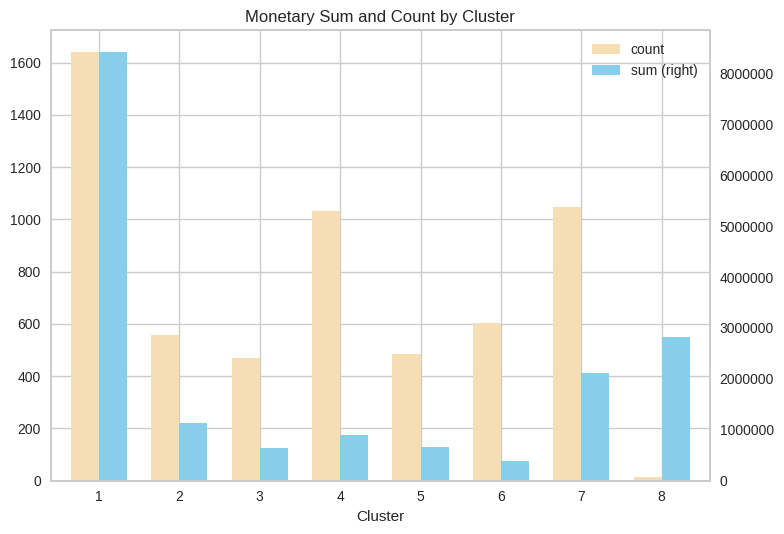

In [ ]:
# # Perform the aggregation on the "Monetary" column by "Cluster"
# aggregated_data = rfm_table_with_cluster.groupBy("Cluster").agg({"Monetary": "sum", "Monetary": "count"})

# # Convert the aggregated data to a Pandas DataFrame
# graph_data = aggregated_data.toPandas()

# # Rename the columns and index
# graph_data.columns = ["Cluster", "Count", "Sum"]
# graph_data.set_index("Cluster", inplace=True)

# # Create the bar plot
# graph_data.plot(width=0.7, kind="bar", rot=0, secondary_y="Sum", color={"Count": "wheat", "Sum": "skyblue"})

# # Set the tick label format for the y-axis
# plt.ticklabel_format(style='plain', axis='y')

# # Set the title and adjust the layout
# plt.title("Monetary Sum and Count by Cluster")
# plt.tight_layout()

# # Display the plot
# plt.show()


import matplotlib.pyplot as plt
import pandas as pd

# Aggregate the data using groupBy and agg functions
graph_spark = rfm_table_with_cluster.groupBy("Cluster") \
    .agg(ff.count("Monetary").alias("count"),
         ff.sum("Monetary").alias("sum")) \
    .orderBy("Cluster")  # Sort by Cluster

# Convert the aggregated Spark DataFrame to a Pandas DataFrame
graph_pd = graph_spark.toPandas()
graph_pd.set_index("Cluster", inplace=True)

# Plot the Pandas DataFrame
graph_pd.plot(width=0.7, kind="bar", rot=0, secondary_y="sum", color={"count": "wheat", "sum": "skyblue"})
plt.ticklabel_format(style='plain', axis='y')
plt.title("Monetary Sum and Count by Cluster")
plt.tight_layout()
plt.show()

In [ ]:
pd_scaled_rfm_table = scaled_rfm_table.toPandas()

In [ ]:
from copy import deepcopy
pd_test_scaled = deepcopy(pd_scaled_rfm_table)
df_indexed = pd_test_scaled.set_index("Customer ID")
# df_without_id = df_indexed.drop(columns=["Customer ID"])
# pd_test_scaled.set_index("Customer ID", inplace=True)
# pd_test_scaled.reset_index(drop=True, inplace=True)
# df_indexed = df.set_index("Customer ID")

df_indexed.describe()

,Recency,Frequency,Monetary
count,5852.000000,5852.000000,5852.000000
mean,0.270640,0.010602,0.005015
std,0.282552,0.027476,0.024625
min,0.000000,0.000000,0.000000
25%,0.033875,0.001610,0.000579
50%,0.128726,0.004105,0.001468
75%,0.513550,0.011028,0.003852
max,1.000000,1.000000,1.000000


In [ ]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans as KMeansSKLEARN

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

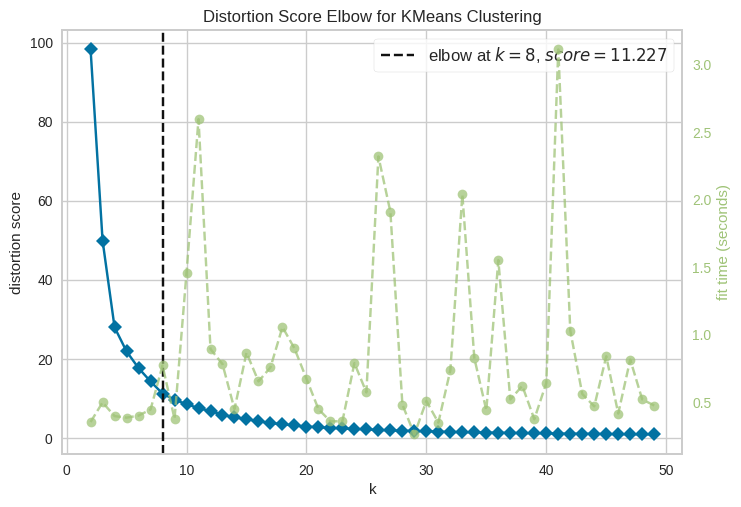

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
kmeans_means = KMeansSKLEARN()
elbow = KElbowVisualizer(kmeans_means, k=(2, 50))
elbow.fit(df_indexed)
elbow.show()

In [ ]:
elbow.elbow_value_

8